In [ ]:
!pip install autogluon matplotlib

# Config

In [1]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = None#'best_quality'

use_is_estimated_attr = True

num_seeds = 3

drop_night_outliers = True

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]


num_stack_levels = 0
num_bag_folds = 4# 8
num_bag_sets = 1#20

use_tune_data = True
use_test_data = False
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

clip_predictions = True

# Loading and preprocessing

In [2]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_no_mean = X[X.index.minute == 0][columns].copy()

    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    X = X.resample('H').mean()

    X[columns] = X_no_mean[columns]

    if date_calc is not None:
        X['date_calc'] = date_calc
    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)
    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1


    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")

    print(f"Size of estimated after dropping nans: {len(X_train[X_train['is_estimated']==1].dropna(subset=['y']))}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in y: 0
Size of estimated after dropping nans: 4418
Processing location B...
Number of nans in y: 4
Size of estimated after dropping nans: 3625
Processing location C...
Number of nans in y: 6059
Size of estimated after dropping nans: 2954


## Feature enginering

### Remove anomalies

In [3]:
def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]
            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [4]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9285


In [5]:
thresh = 0.1
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)
if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

In [6]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  1876


In [7]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [8]:
from sklearn.model_selection import train_test_split
def strat_split(x, test_size=0.2, seed=42):
    # create stratified column, location, week, y (mapped to boolean, 0 or bigger)
    strat = x["location"] + "_" + x["ds"].dt.week.astype('str') + "_" + x["y"].apply(lambda x: 0 if x == 0 else 1).astype('str')
    #print(x["strat"])
    print(f"Number of unique strats: {len(strat.unique())}")
    print(f"Lengt of strat: {len(strat)}")

    # check if there are any strats with only one row
    for s in strat.unique():
        if len(x[strat == s]) == 1:
            print(f"Strat {s} has only one row")
            # set equal to another strat with more rows
            strat[strat == s] = strat.unique()[0]

    # split
    train, test = train_test_split(x, test_size=test_size, random_state=seed, stratify=strat)
    

    return train, test


In [9]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_sets = [pd.DataFrame()]*num_seeds
tune_sets = [pd.DataFrame()]*num_seeds
new_train_sets = [pd.DataFrame()]*num_seeds


for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    # 3 different seeds
    for i in range(num_seeds):
        holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])
    
        loc_new_train_set, loc_tune_set = strat_split(estimated_set[estimated_set["location"] == location], holdout_frac, seed=i)
        new_train_sets[i] = pd.concat([new_train_sets[i], loc_new_train_set])

        if use_test_data:
            loc_tune_set, loc_test_set = strat_split(loc_tune_set, 0.2, seed=i+1)
            test_sets[i] = pd.concat([test_sets[i], loc_test_set])

        tune_sets[i] = pd.concat([tune_sets[i], loc_tune_set])


train_data_list = [pd.concat([train_set, new_train_set]) for new_train_set in new_train_sets]
tuning_data_list = tune_sets
    
test_data_list = [pd.DataFrame()]*num_seeds
if use_test_data:
    test_data_list = test_sets
    for i in range(num_seeds):
        print("Shape of test", test_data_list[i].shape[0])


train_data_list = [TabularDataset(train_data) for train_data in train_data_list]
tuning_data_list = [TabularDataset(tuning_data) for tuning_data in tuning_data_list]

if use_test_data:
    test_data_list = [TabularDataset(test_data) for test_data in test_data_list]

Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 54
Lengt of strat: 4216
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 49
Lengt of strat: 3535
Number of unique strats: 46
Lengt of strat: 2925
Number of unique strats: 46
Lengt of strat: 2925
Number of unique strats: 46
Lengt of strat: 2925


# Modeling

In [10]:
import os

# if submissions folder does not exist, create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

print("New filename:", new_filename)

Last submission number: 134
Now creating submission number: 135
New filename: submission_135


In [11]:
predictors = [None, None, None]

In [12]:
# to mean ensemble different seeds
class NaiveEnsemble:
    def __init__(self, predictors):
        self.predictors = predictors

    def predict(self, x):
        predictions = []
        for predictor in self.predictors:
            predictions.append(predictor.predict(x))
        return np.mean(predictions, axis=0)

In [13]:
from autogluon.common import space
def fit_predictor_for_location(loc):
    different_seeds_predictors = []
    for i, (train_data, tuning_data, test_data) in enumerate(zip(train_data_list, tuning_data_list, test_data_list)):
        print(f"Training model for location {loc}, seed {i}...")

        hyperparameters = {
            'NN_TORCH': {},
            'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
            'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}],#, {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}],
            'FASTAI': {},
            'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
        }



        predictor = TabularPredictor(
            label=label, 
            eval_metric=metric, 
            path=f"AutogluonModels/{new_filename}_{loc}_seed_{i}", 
        ).fit(
            train_data=train_data[train_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
            time_limit=time_limit, 
            presets=presets, 
            num_stack_levels=num_stack_levels,
            num_bag_folds=num_bag_folds,
            num_bag_sets=num_bag_sets,
            tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
            use_bag_holdout=use_bag_holdout,
            hyperparameters=hyperparameters,
            #hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
            excluded_model_types=["XT"] if loc == "C" else ["KNN"] if loc=="B" else ["KNN", "XT"]
        )

        # evaluate on test data
        if use_test_data:
            t = test_data[test_data["location"] == loc]
            perf = predictor.evaluate(t)
            print("Evaluation on test data:")
            print(perf[predictor.eval_metric.name])

        different_seeds_predictors.append(predictor)

    return NaiveEnsemble(different_seeds_predictors)

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_135_A_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   97.48 GB / 494.38 GB (19.7%)
Train Data Rows:    31283
Train Data Columns: 44


Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 668.96033, 1193.25339)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])


Training model for location A, seed 0...


Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2665.18 MB
	Train Data (Original)  Memory Usage: 13.18 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not ne

[1000]	valid_set's l1: 186.407
[2000]	valid_set's l1: 180.811
[3000]	valid_set's l1: 178.703
[4000]	valid_set's l1: 177.468
[5000]	valid_set's l1: 176.675
[6000]	valid_set's l1: 176.133
[7000]	valid_set's l1: 175.694
[8000]	valid_set's l1: 175.442
[9000]	valid_set's l1: 175.106
[10000]	valid_set's l1: 174.861
[1000]	valid_set's l1: 181.804
[2000]	valid_set's l1: 176.681
[3000]	valid_set's l1: 174.392
[4000]	valid_set's l1: 173.268
[5000]	valid_set's l1: 172.615
[6000]	valid_set's l1: 171.97
[7000]	valid_set's l1: 171.567
[8000]	valid_set's l1: 171.347
[9000]	valid_set's l1: 171.049
[10000]	valid_set's l1: 170.852
[1000]	valid_set's l1: 186.57
[2000]	valid_set's l1: 181.782
[3000]	valid_set's l1: 179.513
[4000]	valid_set's l1: 178.388
[5000]	valid_set's l1: 177.319
[6000]	valid_set's l1: 176.817
[7000]	valid_set's l1: 176.437
[8000]	valid_set's l1: 176.183
[9000]	valid_set's l1: 176.009
[10000]	valid_set's l1: 175.862
[1000]	valid_set's l1: 184.465
[2000]	valid_set's l1: 180.06
[3000]	v

	-90.8173	 = Validation score   (-mean_absolute_error)
	1188.88s	 = Training   runtime
	8.79s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-107.3595	 = Validation score   (-mean_absolute_error)
	98.31s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-91.037	 = Validation score   (-mean_absolute_error)
	170.81s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-86.9423	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1473.26s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_A_seed_0/")
Beginning AutoGluon training ...
AutoG

Training model for location A, seed 1...


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 39 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['snow_density:kgm3', 'is_estimated']
	0.1s = Fit runtime
	41 features in original data used to generate 41 features in processed data.
	Tra

[1000]	valid_set's l1: 185.86
[2000]	valid_set's l1: 180.925
[3000]	valid_set's l1: 178.364
[4000]	valid_set's l1: 176.942
[5000]	valid_set's l1: 175.924
[6000]	valid_set's l1: 175.164
[7000]	valid_set's l1: 174.747
[8000]	valid_set's l1: 174.337
[9000]	valid_set's l1: 174.05
[10000]	valid_set's l1: 173.871
[1000]	valid_set's l1: 183.466
[2000]	valid_set's l1: 177.868
[3000]	valid_set's l1: 175.001
[4000]	valid_set's l1: 173.273
[5000]	valid_set's l1: 172.33
[6000]	valid_set's l1: 171.736
[7000]	valid_set's l1: 171.201
[8000]	valid_set's l1: 170.81
[9000]	valid_set's l1: 170.538
[10000]	valid_set's l1: 170.294
[1000]	valid_set's l1: 184.353
[2000]	valid_set's l1: 179.588
[3000]	valid_set's l1: 177.554
[4000]	valid_set's l1: 176.057
[5000]	valid_set's l1: 175.257
[6000]	valid_set's l1: 174.505
[7000]	valid_set's l1: 174.074
[8000]	valid_set's l1: 173.695
[9000]	valid_set's l1: 173.48
[10000]	valid_set's l1: 173.18
[1000]	valid_set's l1: 186.164
[2000]	valid_set's l1: 182.011
[3000]	vali

	-88.1348	 = Validation score   (-mean_absolute_error)
	390.68s	 = Training   runtime
	5.68s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-104.301	 = Validation score   (-mean_absolute_error)
	91.83s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-90.3036	 = Validation score   (-mean_absolute_error)
	203.04s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-84.6001	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 695.14s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_A_seed_1/")
Beginning AutoGluon training ...
AutoGl

Training model for location A, seed 2...


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 39 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', ['bool']) :  2 | ['snow_density:kgm3', 'is_estimated']
	0.1s = Fit runtime
	41 features in original data used to generate 41 features in processed data.
	Tra

[1000]	valid_set's l1: 188.462
[2000]	valid_set's l1: 183.851
[3000]	valid_set's l1: 181.224
[4000]	valid_set's l1: 179.608
[5000]	valid_set's l1: 178.663
[6000]	valid_set's l1: 177.83
[7000]	valid_set's l1: 177.213
[8000]	valid_set's l1: 176.903
[9000]	valid_set's l1: 176.586
[10000]	valid_set's l1: 176.348
[1000]	valid_set's l1: 182.098
[2000]	valid_set's l1: 176.908
[3000]	valid_set's l1: 174.343
[4000]	valid_set's l1: 172.936
[5000]	valid_set's l1: 171.796
[6000]	valid_set's l1: 171.102
[7000]	valid_set's l1: 170.633
[8000]	valid_set's l1: 170.324
[9000]	valid_set's l1: 170.062
[10000]	valid_set's l1: 169.868
[1000]	valid_set's l1: 183.734
[2000]	valid_set's l1: 178.401
[3000]	valid_set's l1: 176.476
[4000]	valid_set's l1: 175.258
[5000]	valid_set's l1: 174.66
[6000]	valid_set's l1: 174.18
[7000]	valid_set's l1: 173.832
[8000]	valid_set's l1: 173.543
[9000]	valid_set's l1: 173.212
[10000]	valid_set's l1: 173.054
[1000]	valid_set's l1: 186.141
[2000]	valid_set's l1: 182.008
[3000]	v

	-84.1869	 = Validation score   (-mean_absolute_error)
	411.68s	 = Training   runtime
	5.47s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-106.4159	 = Validation score   (-mean_absolute_error)
	87.08s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-95.02	 = Validation score   (-mean_absolute_error)
	178.04s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-83.8019	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 686.32s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_A_seed_2/")


In [14]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_135_B_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   97.18 GB / 494.38 GB (19.7%)
Train Data Rows:    27726
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 97.18811, 205.46465)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting Aut

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation:m', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 41 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])  

Training model for location B, seed 0...


Excluded models: ['KNN'] (Specified by `excluded_model_types`)
Fitting 4 L1 models ...
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 25.6148
[2000]	valid_set's l1: 24.6906
[3000]	valid_set's l1: 24.2281
[4000]	valid_set's l1: 23.9808
[5000]	valid_set's l1: 23.8324
[6000]	valid_set's l1: 23.7225
[7000]	valid_set's l1: 23.6433
[8000]	valid_set's l1: 23.5847
[9000]	valid_set's l1: 23.5425
[10000]	valid_set's l1: 23.5139
[1000]	valid_set's l1: 26.0308
[2000]	valid_set's l1: 25.1397
[3000]	valid_set's l1: 24.7868
[4000]	valid_set's l1: 24.5764
[5000]	valid_set's l1: 24.4447
[6000]	valid_set's l1: 24.3359
[7000]	valid_set's l1: 24.252
[8000]	valid_set's l1: 24.1901
[9000]	valid_set's l1: 24.1428
[10000]	valid_set's l1: 24.1077
[1000]	valid_set's l1: 25.734
[2000]	valid_set's l1: 24.9195
[3000]	valid_set's l1: 24.5918
[4000]	valid_set's l1: 24.3772
[5000]	valid_set's l1: 24.2099
[6000]	valid_set's l1: 24.1173
[7000]	valid_set's l1: 24.0647
[8000]	valid_set's l1: 24.0142
[9000]	valid_set's l1: 23.9667
[10000]	valid_set's l1: 23.9351
[1000]	valid_set's l1: 25.1228
[2000]	valid_set's l1: 24.3471
[3000]	

	-12.9526	 = Validation score   (-mean_absolute_error)
	424.05s	 = Training   runtime
	4.93s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-16.1928	 = Validation score   (-mean_absolute_error)
	4.05s	 = Training   runtime
	0.54s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-14.0332	 = Validation score   (-mean_absolute_error)
	63.29s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-12.843	 = Validation score   (-mean_absolute_error)
	124.46s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-11.9999	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 625.76s ... Best model: "WeightedEnsemble_L2"
Tab

Training model for location B, seed 1...
[1000]	valid_set's l1: 25.2449
[2000]	valid_set's l1: 24.3037
[3000]	valid_set's l1: 23.8753
[4000]	valid_set's l1: 23.5841
[5000]	valid_set's l1: 23.4193
[6000]	valid_set's l1: 23.3259
[7000]	valid_set's l1: 23.2657
[8000]	valid_set's l1: 23.212
[9000]	valid_set's l1: 23.1728
[10000]	valid_set's l1: 23.1384
[1000]	valid_set's l1: 26.0656
[2000]	valid_set's l1: 25.2958
[3000]	valid_set's l1: 24.9474
[4000]	valid_set's l1: 24.7526
[5000]	valid_set's l1: 24.6192
[6000]	valid_set's l1: 24.5114
[7000]	valid_set's l1: 24.443
[8000]	valid_set's l1: 24.3915
[9000]	valid_set's l1: 24.3485
[10000]	valid_set's l1: 24.3151
[1000]	valid_set's l1: 25.8566
[2000]	valid_set's l1: 25.0966
[3000]	valid_set's l1: 24.6795
[4000]	valid_set's l1: 24.4395
[5000]	valid_set's l1: 24.3365
[6000]	valid_set's l1: 24.2489
[7000]	valid_set's l1: 24.1748
[8000]	valid_set's l1: 24.1293
[9000]	valid_set's l1: 24.1008
[10000]	valid_set's l1: 24.064
[1000]	valid_set's l1: 24.905

	-13.7308	 = Validation score   (-mean_absolute_error)
	430.37s	 = Training   runtime
	5.46s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-15.7629	 = Validation score   (-mean_absolute_error)
	3.71s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-14.0437	 = Validation score   (-mean_absolute_error)
	60.22s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-12.9556	 = Validation score   (-mean_absolute_error)
	112.52s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-12.7479	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 617.34s ... Best model: "WeightedEnsemble_L2"
Ta

Training model for location B, seed 2...
[1000]	valid_set's l1: 25.2774
[2000]	valid_set's l1: 24.4005
[3000]	valid_set's l1: 23.9775
[4000]	valid_set's l1: 23.7242
[5000]	valid_set's l1: 23.534
[6000]	valid_set's l1: 23.4132
[7000]	valid_set's l1: 23.3423
[8000]	valid_set's l1: 23.2977
[9000]	valid_set's l1: 23.2654
[10000]	valid_set's l1: 23.2342
[1000]	valid_set's l1: 26.082
[2000]	valid_set's l1: 25.2171
[3000]	valid_set's l1: 24.8619
[4000]	valid_set's l1: 24.7072
[5000]	valid_set's l1: 24.5867
[6000]	valid_set's l1: 24.4718
[7000]	valid_set's l1: 24.424
[8000]	valid_set's l1: 24.3675
[9000]	valid_set's l1: 24.3117
[10000]	valid_set's l1: 24.279
[1000]	valid_set's l1: 26.0891
[2000]	valid_set's l1: 25.3011
[3000]	valid_set's l1: 24.8503
[4000]	valid_set's l1: 24.6531
[5000]	valid_set's l1: 24.5209
[6000]	valid_set's l1: 24.4325
[7000]	valid_set's l1: 24.3689
[8000]	valid_set's l1: 24.3101
[9000]	valid_set's l1: 24.2723
[10000]	valid_set's l1: 24.2379
[1000]	valid_set's l1: 25.1859

	-11.9773	 = Validation score   (-mean_absolute_error)
	395.93s	 = Training   runtime
	5.04s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-14.2436	 = Validation score   (-mean_absolute_error)
	3.65s	 = Training   runtime
	0.53s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-11.9233	 = Validation score   (-mean_absolute_error)
	61.85s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-11.6233	 = Validation score   (-mean_absolute_error)
	150.68s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.8261	 = Validation score   (-mean_absolute_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 622.06s ... Best model: "WeightedEnsemble_L2"
Ta

In [15]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_135_C_seed_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   95.82 GB / 494.38 GB (19.4%)
Train Data Rows:    24416
Train Data Columns: 44
Tuning Data Rows:    1500
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 80.49013, 169.23435)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):

Training model for location C, seed 0...


	Train Data (Processed) Memory Usage: 8.14 MB (0.3% of available memory)
Data preprocessing and feature engineering runtime = 0.18s ...
AutoGluon will gauge predictive performance using evaluation metric: 'mean_absolute_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
use_bag_holdout=True, will use tuning_data as holdout (will not be used for early stopping).
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}],
	'FASTAI': {},
	'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
}
Excluded models: ['XT'] (Specified by `excluded_model_types`)
Fitting 5

[1000]	valid_set's l1: 19.8841
[2000]	valid_set's l1: 19.185
[3000]	valid_set's l1: 18.8975
[4000]	valid_set's l1: 18.778
[5000]	valid_set's l1: 18.6929
[6000]	valid_set's l1: 18.6535
[7000]	valid_set's l1: 18.6184
[8000]	valid_set's l1: 18.5983
[9000]	valid_set's l1: 18.5886
[10000]	valid_set's l1: 18.5756
[1000]	valid_set's l1: 19.9507
[2000]	valid_set's l1: 19.5225
[3000]	valid_set's l1: 19.3448
[4000]	valid_set's l1: 19.2153
[5000]	valid_set's l1: 19.1374
[6000]	valid_set's l1: 19.0734
[7000]	valid_set's l1: 19.0495
[8000]	valid_set's l1: 19.0279
[9000]	valid_set's l1: 19.0007
[10000]	valid_set's l1: 18.9812
[1000]	valid_set's l1: 19.806
[2000]	valid_set's l1: 19.3481
[3000]	valid_set's l1: 19.0937
[4000]	valid_set's l1: 18.9537
[5000]	valid_set's l1: 18.8796
[6000]	valid_set's l1: 18.8083
[7000]	valid_set's l1: 18.7683
[8000]	valid_set's l1: 18.7399
[9000]	valid_set's l1: 18.7165
[10000]	valid_set's l1: 18.6987
[1000]	valid_set's l1: 20.2019
[2000]	valid_set's l1: 19.7324
[3000]	v

	-11.911	 = Validation score   (-mean_absolute_error)
	358.62s	 = Training   runtime
	4.82s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-13.8737	 = Validation score   (-mean_absolute_error)
	62.0s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-14.6896	 = Validation score   (-mean_absolute_error)
	129.3s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-11.8181	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1085.18s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_C_seed_0/")
Beginning AutoGluon training ...
AutoGluo

Training model for location C, seed 1...


Excluded models: ['XT'] (Specified by `excluded_model_types`)
Fitting 5 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ...
	-19.3166	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	261.23s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	-19.557	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	256.96s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.9231
[2000]	valid_set's l1: 19.175
[3000]	valid_set's l1: 18.8647
[4000]	valid_set's l1: 18.7158
[5000]	valid_set's l1: 18.6509
[6000]	valid_set's l1: 18.5904
[7000]	valid_set's l1: 18.5611
[8000]	valid_set's l1: 18.5395
[9000]	valid_set's l1: 18.5277
[10000]	valid_set's l1: 18.5149
[1000]	valid_set's l1: 19.8149
[2000]	valid_set's l1: 19.4109
[3000]	valid_set's l1: 19.2424
[4000]	valid_set's l1: 19.1032
[5000]	valid_set's l1: 19.0073
[6000]	valid_set's l1: 18.9629
[7000]	valid_set's l1: 18.9311
[8000]	valid_set's l1: 18.9001
[9000]	valid_set's l1: 18.8828
[10000]	valid_set's l1: 18.8703
[1000]	valid_set's l1: 20.0125
[2000]	valid_set's l1: 19.481
[3000]	valid_set's l1: 19.2603
[4000]	valid_set's l1: 19.1331
[5000]	valid_set's l1: 19.0357
[6000]	valid_set's l1: 18.983
[7000]	valid_set's l1: 18.9291
[8000]	valid_set's l1: 18.8895
[9000]	valid_set's l1: 18.8684
[10000]	valid_set's l1: 18.8561
[1000]	valid_set's l1: 19.843
[2000]	valid_set's l1: 19.3944
[3000]	va

	-11.6036	 = Validation score   (-mean_absolute_error)
	386.03s	 = Training   runtime
	4.34s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-13.9424	 = Validation score   (-mean_absolute_error)
	46.87s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-12.9681	 = Validation score   (-mean_absolute_error)
	96.32s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-11.2763	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1087.16s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_C_seed_1/")
Beginning AutoGluon training ...
AutoGlu

Training model for location C, seed 2...


	-18.9068	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	67.67s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	-19.1828	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	62.55s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.0021
[2000]	valid_set's l1: 19.3401
[3000]	valid_set's l1: 19.0783
[4000]	valid_set's l1: 18.9353
[5000]	valid_set's l1: 18.8397
[6000]	valid_set's l1: 18.803
[7000]	valid_set's l1: 18.7725
[8000]	valid_set's l1: 18.7409
[9000]	valid_set's l1: 18.7282
[10000]	valid_set's l1: 18.7196
[1000]	valid_set's l1: 19.8814
[2000]	valid_set's l1: 19.3389
[3000]	valid_set's l1: 19.1017
[4000]	valid_set's l1: 18.9955
[5000]	valid_set's l1: 18.9092
[6000]	valid_set's l1: 18.8616
[7000]	valid_set's l1: 18.8271
[8000]	valid_set's l1: 18.7981
[9000]	valid_set's l1: 18.7722
[10000]	valid_set's l1: 18.7599
[1000]	valid_set's l1: 19.7175
[2000]	valid_set's l1: 19.2905
[3000]	valid_set's l1: 19.0629
[4000]	valid_set's l1: 18.931
[5000]	valid_set's l1: 18.8302
[6000]	valid_set's l1: 18.762
[7000]	valid_set's l1: 18.7311
[8000]	valid_set's l1: 18.7067
[9000]	valid_set's l1: 18.686
[10000]	valid_set's l1: 18.6615
[1000]	valid_set's l1: 20.0883
[2000]	valid_set's l1: 19.6453
[3000]	va

	-10.5141	 = Validation score   (-mean_absolute_error)
	315.92s	 = Training   runtime
	4.27s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-12.4664	 = Validation score   (-mean_absolute_error)
	46.71s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 4 child models (S1F1 - S1F4) | Fitting with SequentialLocalFoldFittingStrategy
	-12.7414	 = Validation score   (-mean_absolute_error)
	108.96s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.4078	 = Validation score   (-mean_absolute_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 617.64s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_135_C_seed_2/")


In [16]:
# analyse weights in ensemble
for i in range(len(predictors)):
    for j in range(len(predictors[i].predictors)):
        print(f"Predictor {i}, seed {j}:")
        print(predictors[i].predictors[j].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

Predictor 0, seed 0:
{'LightGBMXT_BAG_L1': 0.515625, 'NeuralNetTorch_BAG_L1': 0.484375}
Predictor 0, seed 1:
{'LightGBMXT_BAG_L1': 0.5535714285714286, 'NeuralNetFastAI_BAG_L1': 0.05357142857142857, 'NeuralNetTorch_BAG_L1': 0.39285714285714285}
Predictor 0, seed 2:
{'LightGBMXT_BAG_L1': 0.8297872340425532, 'NeuralNetFastAI_BAG_L1': 0.02127659574468085, 'NeuralNetTorch_BAG_L1': 0.14893617021276595}
Predictor 1, seed 0:
{'LightGBMXT_BAG_L1': 0.4883720930232558, 'NeuralNetFastAI_BAG_L1': 0.046511627906976744, 'NeuralNetTorch_BAG_L1': 0.46511627906976744}
Predictor 1, seed 1:
{'LightGBMXT_BAG_L1': 0.3111111111111111, 'NeuralNetFastAI_BAG_L1': 0.06666666666666667, 'NeuralNetTorch_BAG_L1': 0.6222222222222222}
Predictor 1, seed 2:
{'LightGBMXT_BAG_L1': 0.37333333333333335, 'NeuralNetFastAI_BAG_L1': 0.2, 'NeuralNetTorch_BAG_L1': 0.4266666666666667}
Predictor 2, seed 0:
{'KNeighborsUnif_BAG_L1': 0.03225806451612903, 'LightGBMXT_BAG_L1': 0.8709677419354839, 'NeuralNetFastAI_BAG_L1': 0.09677419354

# Submit

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])
#test_data

NameError: name 'TabularDataset' is not defined

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred * 1.018 if loc=="A" else pred
    predictions.append(subset)

NameError: name 'future_test_data' is not defined

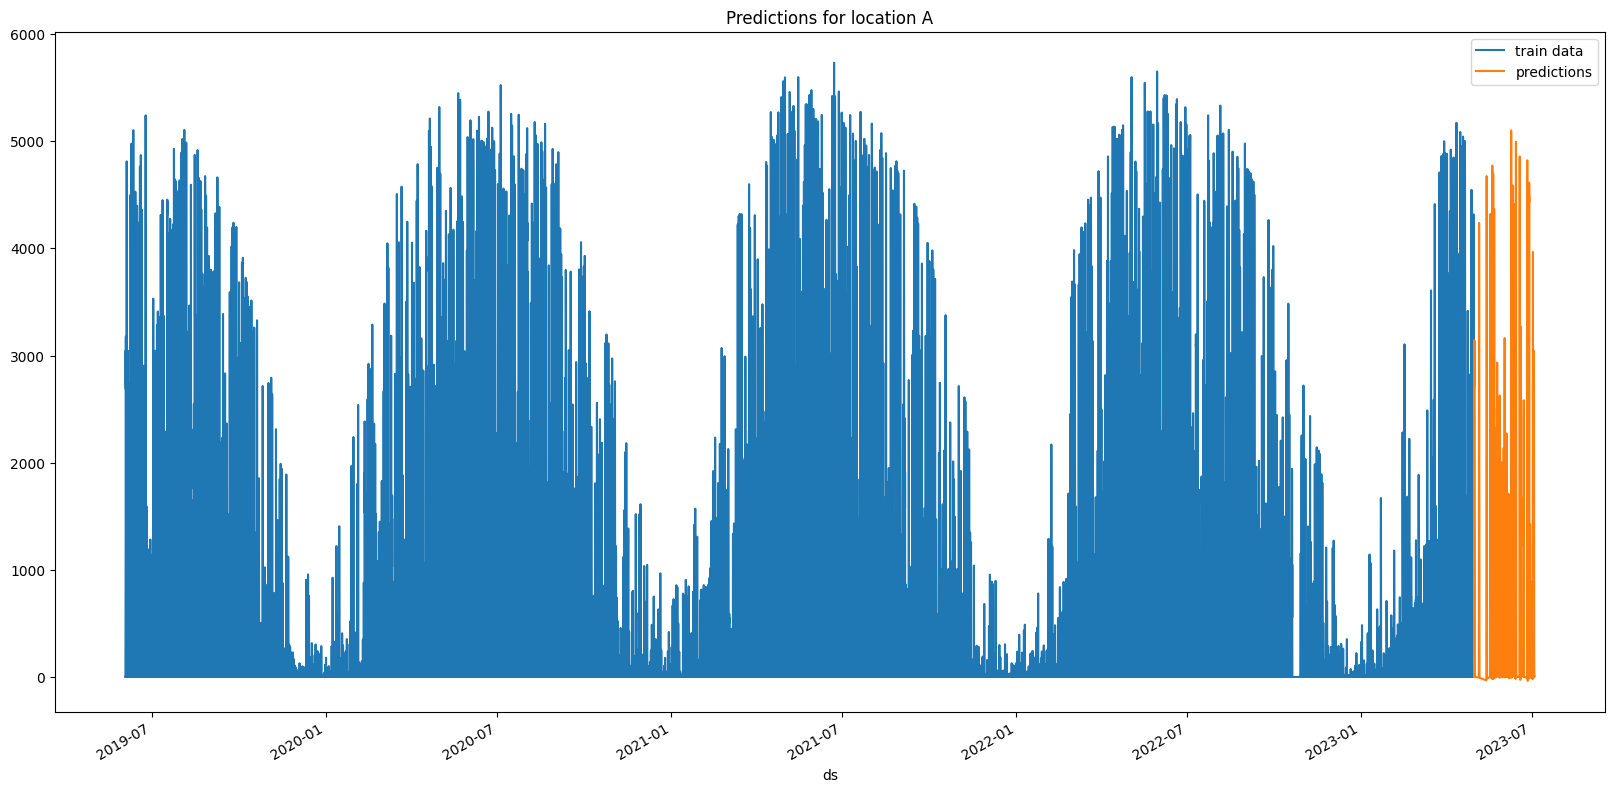

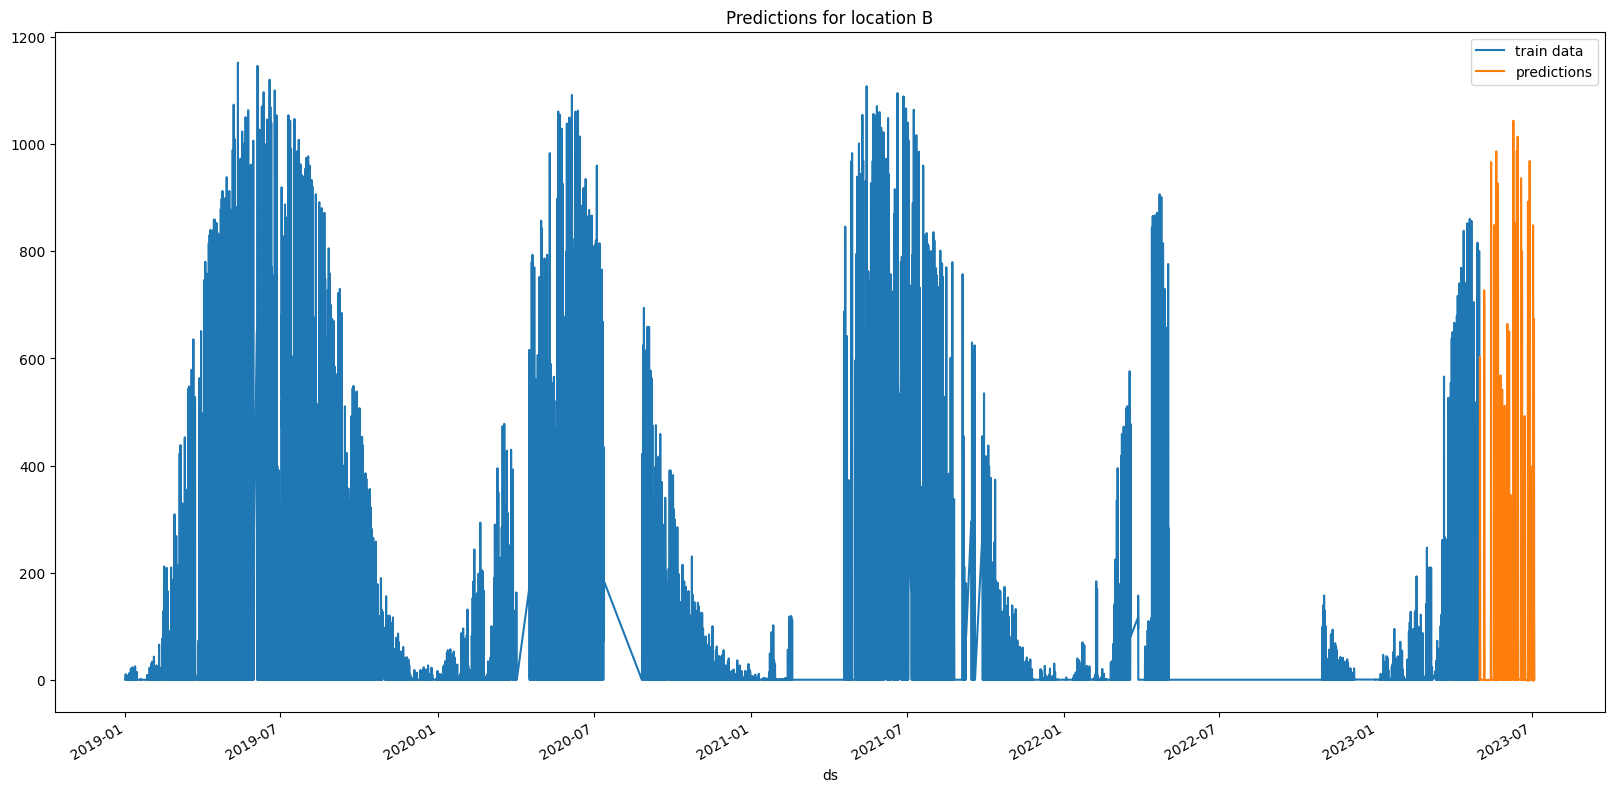

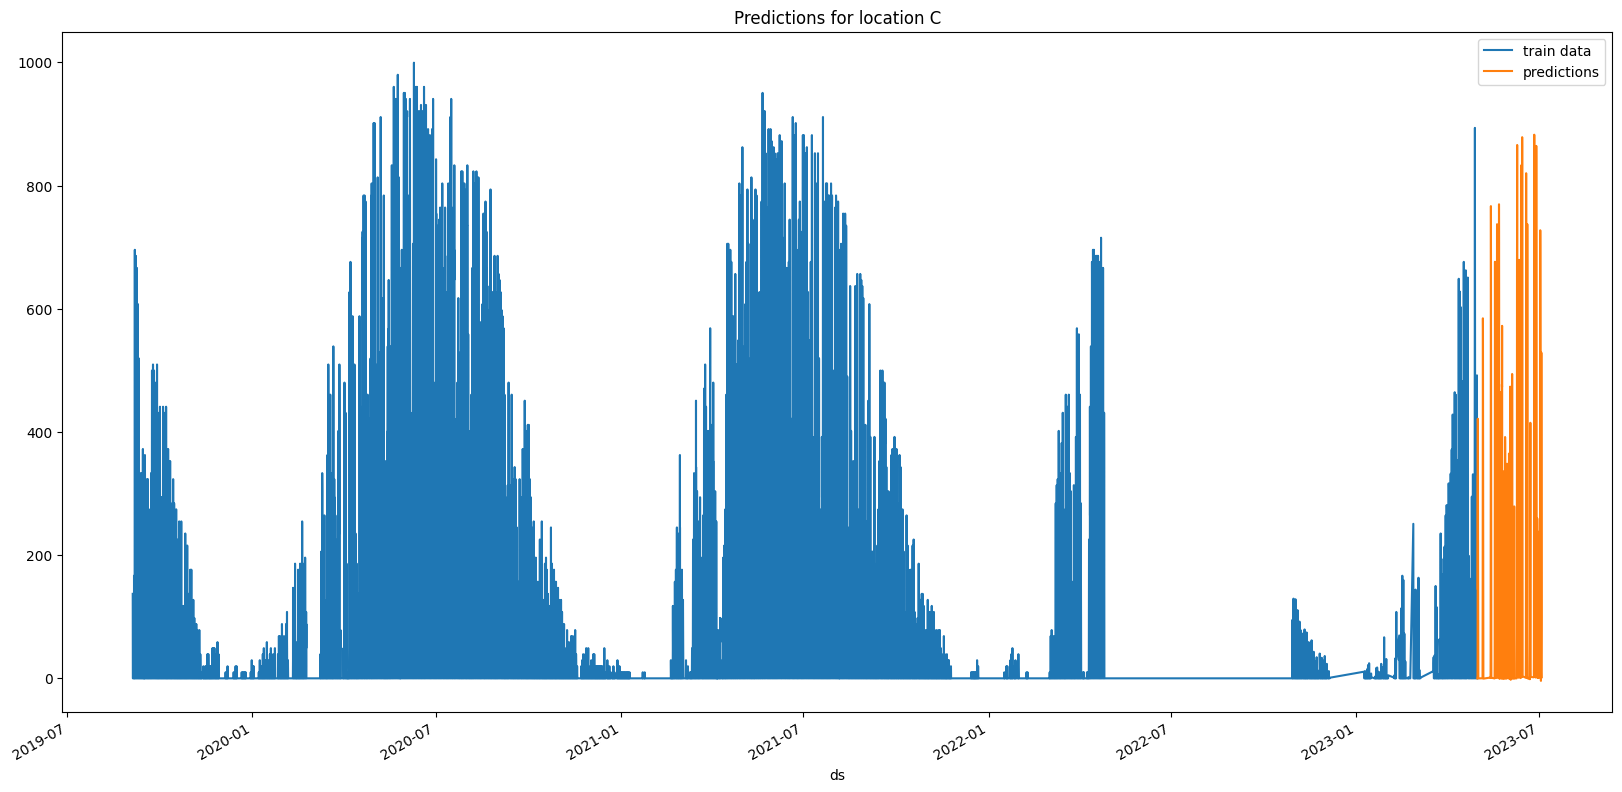

In [ ]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_list[0][train_data_list[0]["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -36.679443
Smallest prediction after clipping: 0.0
Smallest prediction: -2.0192268
Smallest prediction after clipping: 0.0
Smallest prediction: -4.132155
Smallest prediction after clipping: 0.0


,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,19.348206
4,4,328.040344
...,...,...
715,2155,71.983177
716,2156,41.322773
717,2157,11.143418
718,2158,2.678588


In [ ]:
# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_135.csv


In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "short_2.ipynb"])

[NbConvertApp] Converting notebook short_2.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_135_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_135_files/notebook_pdfs
[NbConvertApp] Writing 214353 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 346214 bytes to notebook_pdfs/submission_135.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_135.pdf', 'short_2.ipynb'], returncode=0)